## Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.  
  
1. Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
2. Нужно собрать данные по клиентам по следующим группам:
Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.    
  
Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.  
В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.  
Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.  

## Описание данных

market_file.csv  
Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.  
id — номер покупателя в корпоративной базе данных.  
Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».  
Тип сервиса — уровень сервиса, например «премиум» и «стандарт».  
Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.  
Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.  
Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.  
Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.  
Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.  
Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.  
Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.  
Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.  
Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.  
Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.  
  
market_money.csv  
Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.  
id — номер покупателя в корпоративной базе данных.  
Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.  
Выручка — сумма выручки за период.  
  
market_time.csv  
Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.  
id — номер покупателя в корпоративной базе данных.  
Период — название периода, во время которого зафиксировано общее время.  
минут — значение времени, проведённого на сайте, в минутах.  
    
money.csv  
Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.  
id — номер покупателя в корпоративной базе данных.  
Прибыль — значение прибыли.  

## Загрузка данных

In [1]:
!pip install shap -q # -q убирает необязательные выводы в командах Linux

In [2]:
!pip install phik

     |████████████████████████████████| 686 kB 2.2 MB/s eta 0:00:01


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
import math
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import plotly
from plotly.express import scatter

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

from sklearn.impute import SimpleImputer 

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from warnings import simplefilter

import shap
import phik

In [4]:
data_file = pd.read_csv('/datasets/market_file.csv', sep=',')
data_money = pd.read_csv('/datasets/market_money.csv', sep=',')
data_time = pd.read_csv('/datasets/market_time.csv', sep=',')
data_profit = pd.read_csv('/datasets/money.csv', sep=';', decimal = ',')

In [5]:
data_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [6]:
data_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [7]:
data_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [8]:
data_profit.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Данных для выполнения исследовательской работы достаточно. В данных есть небольшие проблемы, которые необходимо устранить для успешного выполнения работы. Содержимое таблиц соответсвует описанию.

##  Предобработка данных

In [9]:
data_file.info()
data_money.info()
data_time.info()
data_profit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

### Переименование столбцов

In [10]:
data_file.columns = data_file.columns.str.replace(' ', '_').str.lower()
data_money.columns = data_money.columns.str.lower()
data_time.columns = data_time.columns.str.lower()
data_profit.columns = data_profit.columns.str.lower()

### Обработка значений

Исправим ошибку в написании слова предыдущий:

In [11]:
data_time['период'].value_counts()

предыдцщий_месяц    1300
текущий_месяц       1300
Name: период, dtype: int64

In [12]:
data_time.loc[data_time['период'] == 'предыдцщий_месяц', 'период'] = 'предыдущий_месяц'

Удалим аномалию в столбце выручка:

In [13]:
data_money['выручка'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64

In [14]:
data_money = data_money.query('выручка < 106862')

### Дубликаты

Удалим явные дубликаты

In [15]:
data_file = data_file.drop_duplicates()

В столбце тип сервиса присутсвует видимо по-разному написанное значение. Исправим это:

In [16]:
data_file['тип_сервиса'].value_counts()

стандарт     914
премиум      376
стандартт     10
Name: тип_сервиса, dtype: int64

In [17]:
data_file.loc[data_file['тип_сервиса'] == 'стандартт', 'тип_сервиса'] = 'стандарт'

### Вывод

Названия столбцов были приведены к нижнему регистру, были обработаны явные инеявные дубликаты, устранены аномалии, исправлены ошибки в написании

## Исследовательский анализ

В первую очередь нас интересуют клиенты за последние 3 месяца, поэтому отберем только их.

In [18]:
data_profit['прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

В этой таблице находятся данные о прибыли от клиентов за последние 3 месяца, значит здесь те клиенты, которые нас интересуют. Размерность у нее такая же как и у остальных, а значит все клиенты что-то покупали в течении последних трех месяцев. 

### маркет_актив_6_мес

In [19]:
data_file.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64


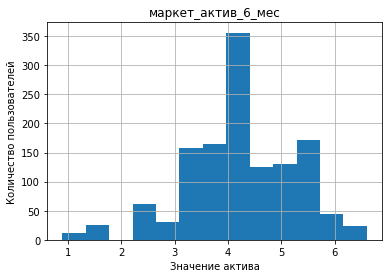

In [20]:
print(data_file['маркет_актив_6_мес'].describe())
data_file['маркет_актив_6_мес'].hist(bins=13)
plt.title("маркет_актив_6_мес")
plt.ylabel("Количество пользователей")
plt.xlabel("Значение актива")
None

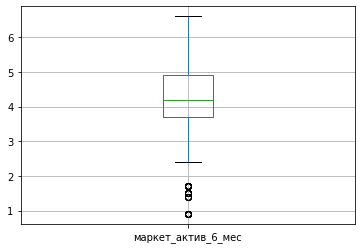

In [21]:
data_file.boxplot(column='маркет_актив_6_мес')
None

В целом распределение выглядит нормальным, что может говорить о достоверности графика.

Были обнаружены выбросы

### маркет_актив_тек_мес

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: маркет_актив_тек_мес, dtype: float64


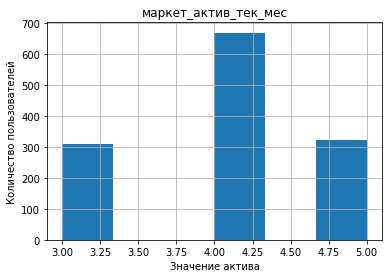

In [22]:
print(data_file['маркет_актив_тек_мес'].describe())
data_file['маркет_актив_тек_мес'].hist(bins=6)
plt.title("маркет_актив_тек_мес")
plt.ylabel("Количество пользователей")
plt.xlabel("Значение актива")
None

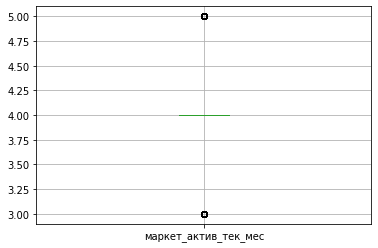

In [23]:
data_file.boxplot(column='маркет_актив_тек_мес')
None

In [24]:
low_percentele = 0.01
hihg_percentele = 0.99

feature_low = data_file['маркет_актив_тек_мес'].quantile(low_percentele)
feature_high = data_file['маркет_актив_тек_мес'].quantile(hihg_percentele)

print(f'Нижняя граница  {feature_low}')
print(f'Верхняя граница  {feature_high}')

print(
    'Процент отброшенных значений = ',
    round(
        100 - len(data_file.query('@feature_low <= маркет_актив_тек_мес <= @feature_high'))
        / len(data_file['маркет_актив_тек_мес']) * 100,
        2
    ),
    '%'
)

Нижняя граница  3.0
Верхняя граница  5.0
Процент отброшенных значений =  0.0 %


В данном случае думаю что удалять выбросы не имеет смысла, так как у нас всего 3 значения

### длительность

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64


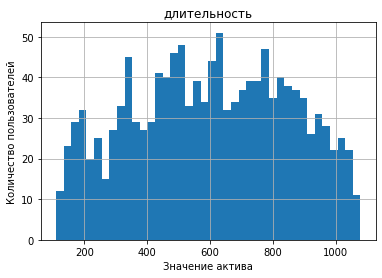

In [25]:
print(data_file['длительность'].describe())
data_file['длительность'].hist(bins=40)
plt.title("длительность")
plt.ylabel("Количество пользователей")
plt.xlabel("Значение актива")
None

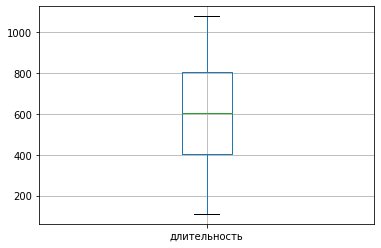

In [26]:
data_file.boxplot(column='длительность')
None

Выбросов не обнаружено

### акционные_покупки

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64


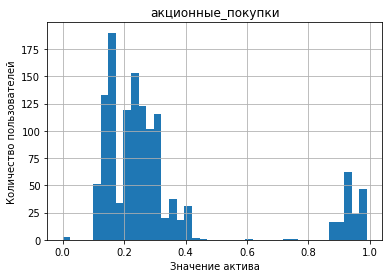

In [27]:
print(data_file['акционные_покупки'].describe())
data_file['акционные_покупки'].hist(bins=40)
plt.title("акционные_покупки")
plt.ylabel("Количество пользователей")
plt.xlabel("Значение актива")
None

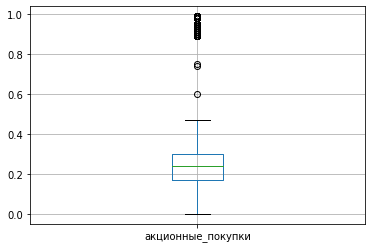

In [28]:
data_file.boxplot(column='акционные_покупки')
None

Данные можно разделить на 2 кластера, однако второй кластер настолько малочисленный, что анализ с помощью ящика-с-усами весь второй кластер определяет как выбросы.

Были обнаружены выбросы

### средний_просмотр_категорий_за_визит

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: средний_просмотр_категорий_за_визит, dtype: float64


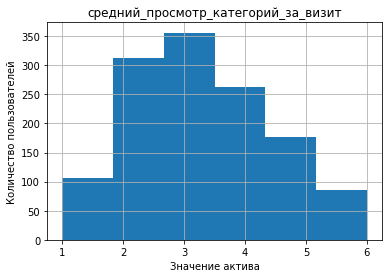

In [29]:
print(data_file['средний_просмотр_категорий_за_визит'].describe())
data_file['средний_просмотр_категорий_за_визит'].hist(bins=6)
plt.title("средний_просмотр_категорий_за_визит")
plt.ylabel("Количество пользователей")
plt.xlabel("Значение актива")
None

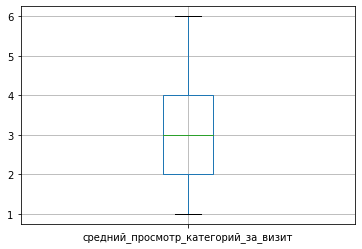

In [30]:
data_file.boxplot(column='средний_просмотр_категорий_за_визит')
None

В целом распределение выглядит нормальным, что может говорить о достоверности графика.

Выбросов не обнаружено

### неоплаченные_продукты_штук_квартал

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64


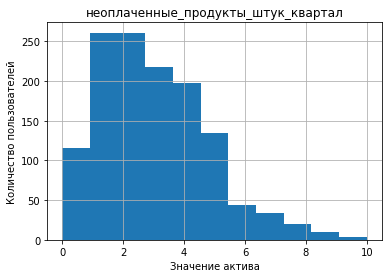

In [31]:
print(data_file['неоплаченные_продукты_штук_квартал'].describe())
data_file['неоплаченные_продукты_штук_квартал'].hist(bins=11)
plt.title("неоплаченные_продукты_штук_квартал")
plt.ylabel("Количество пользователей")
plt.xlabel("Значение актива")
None

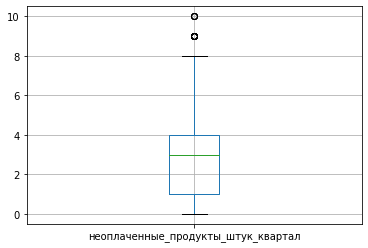

In [32]:
data_file.boxplot(column='неоплаченные_продукты_штук_квартал')
None

В целом распределение выглядит нормальным, что может говорить о достоверности графика.

Были обнаружены выбросы

### ошибка_сервиса

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64


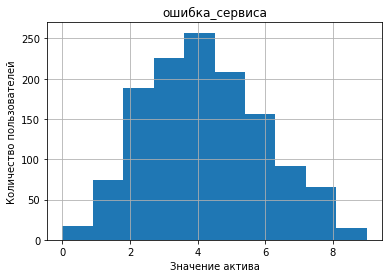

In [33]:
print(data_file['ошибка_сервиса'].describe())
data_file['ошибка_сервиса'].hist(bins=10)
plt.title("ошибка_сервиса")
plt.ylabel("Количество пользователей")
plt.xlabel("Значение актива")
None

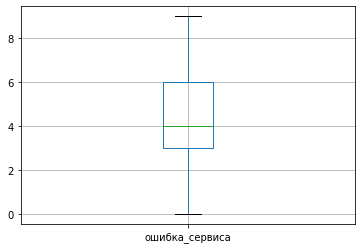

In [34]:
data_file.boxplot(column='ошибка_сервиса')
None

В целом распределение выглядит нормальным, что может говорить о достоверности графика.

Выбросов не обнаружено

### страниц_за_визит

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64


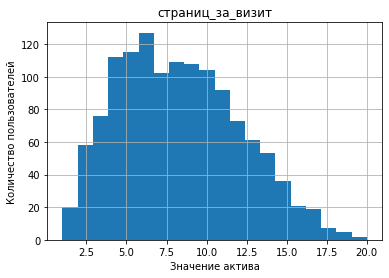

In [35]:
print(data_file['страниц_за_визит'].describe())
data_file['страниц_за_визит'].hist(bins=20)
plt.title("страниц_за_визит")
plt.ylabel("Количество пользователей")
plt.xlabel("Значение актива")
None

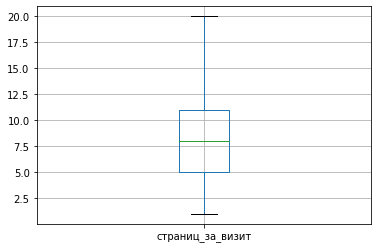

In [36]:
data_file.boxplot(column='страниц_за_визит')
None

В целом распределение выглядит нормальным, что может говорить о достоверности графика.

Выбросов не обнаружено

### выручка

count    3899.00000
mean     4999.57743
std       706.99988
min         0.00000
25%      4590.10000
50%      4957.00000
75%      5363.00000
max      7799.40000
Name: выручка, dtype: float64


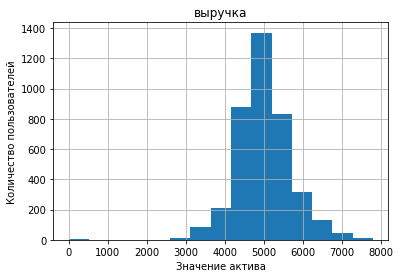

In [37]:
print(data_money['выручка'].describe())
data_money['выручка'].hist(bins=15)
plt.title("выручка")
plt.ylabel("Количество пользователей")
plt.xlabel("Значение актива")
None

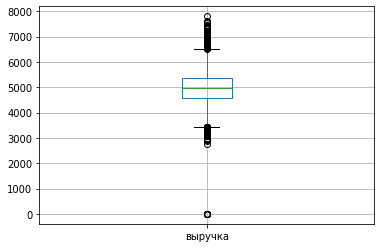

In [38]:
data_money.boxplot(column='выручка')
None

В целом распределение выглядит нормальным, что может говорить о достоверности графика.

Были обнаружены выбросы

In [39]:
#Теперь удалим выброс
data_money = data_money.query('выручка > 0')

### минут

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64


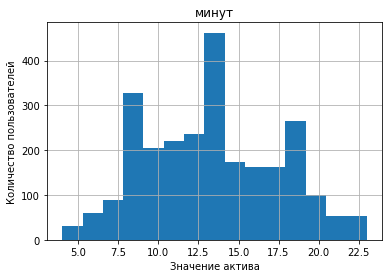

In [40]:
print(data_time['минут'].describe())
data_time['минут'].hist(bins=15)
plt.title("минут")
plt.ylabel("Количество пользователей")
plt.xlabel("Значение актива")
None

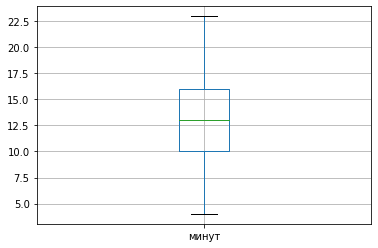

In [41]:
data_time.boxplot(column='минут')
None

В целом распределение выглядит нормальным, что может говорить о достоверности графика.

Выбросов не обнаружено

### прибыль

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64


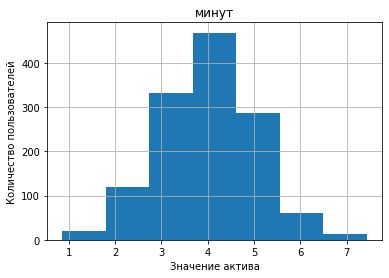

In [42]:
print(data_profit['прибыль'].describe())
data_profit['прибыль'].hist(bins=7)
plt.title("минут")
plt.ylabel("Количество пользователей")
plt.xlabel("Значение актива")
None

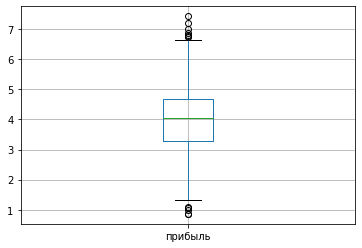

In [43]:
data_profit.boxplot(column='прибыль')
None

В целом распределение выглядит нормальным, что может говорить о достоверности графика.

Были обнаружены выбросы

### Вывод

Данные вполне адекватные, поэтому выбросы я не убрал.

## Объединение таблиц

In [44]:
data_time_merge = pd.pivot_table(data_time, index=['id'], columns='период')
data_time_merge.columns = [ 'минут_предыдущий_месяц', 'минут_текущий_месяц']
data_time_merge.head()

,минут_предыдущий_месяц,минут_текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


In [45]:
data_money_merge = pd.pivot_table(data_money, index=['id'], columns='период').fillna(0)
data_money_merge.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
data_money_merge.head()

,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


In [46]:
data_money_merge = data_money_merge.query('выручка_предыдущий_месяц > 0 and выручка_препредыдущий_месяц > 0 and выручка_текущий_месяц > 0')

In [47]:
data_unity = data_file.merge(data_time_merge, on='id').merge(
    data_money_merge, on='id').merge(
    data_profit, on='id')

In [48]:
data_unity

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_предыдущий_месяц,минут_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,прибыль
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10,5216.0,4472.0,4971.6,4.16
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4,3.13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13,6158.0,4793.0,6610.4,4.87
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11,5807.5,4594.0,5872.5,4.21
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10,4738.5,5124.0,5388.5,3.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,14,7,3664.0,4704.0,4741.7,4.44
1292,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,12,11,4729.0,5299.0,5353.0,6.11
1293,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,12,18,5160.0,5334.0,5139.2,3.29
1294,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,18,7,4923.0,4725.0,5224.6,4.03


In [49]:
data_unity.drop(['id'], axis=1).query('покупательская_активность == "Снизилась"').head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_предыдущий_месяц,минут_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,прибыль
0,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10,5216.0,4472.0,4971.6,4.16
1,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4,3.13
2,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13,6158.0,4793.0,6610.4,4.87
3,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11,5807.5,4594.0,5872.5,4.21
4,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10,4738.5,5124.0,5388.5,3.95


## Корреляция

Матрица корреляции Фика с целевым полем.

In [50]:
data_unity.drop(['id'], axis=1).phik_matrix(interval_cols=['акционные_покупки', 
                                                           'средний_просмотр_категорий_за_визит', 
                                                            'выручка_предыдущий_месяц', 
                                                            'выручка_препредыдущий_месяц', 
                                                            'выручка_текущий_месяц', 'прибыль'])

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_предыдущий_месяц,минут_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,прибыль
покупательская_активность,1.000000,0.129940,0.000000,0.611327,0.000000,0.000000,0.506276,0.299717,0.539607,0.405041,0.224154,0.747331,0.604355,0.569983,0.224638,0.497393,0.197213,0.000000
тип_сервиса,0.129940,1.000000,0.289965,0.102139,0.045258,0.611909,0.030010,0.070809,0.185391,0.113015,0.079515,0.087776,0.121210,0.061764,0.000000,0.069704,0.124216,0.000000
разрешить_сообщать,0.000000,0.289965,1.000000,0.073658,0.052618,0.607184,0.012198,0.073684,0.070359,0.162524,0.021839,0.097094,0.063528,0.000000,0.080842,0.000000,0.060907,0.034982
маркет_актив_6_мес,0.611327,0.102139,0.073658,1.000000,0.124113,0.702905,0.425154,0.198302,0.325088,0.239298,0.195136,0.410959,0.382578,0.365468,0.159376,0.347011,0.145184,0.000000
маркет_актив_тек_мес,0.000000,0.045258,0.052618,0.124113,1.000000,0.675822,0.000000,0.136243,0.246633,0.142887,0.116946,0.000000,0.166871,0.079883,0.051824,0.000000,0.000000,0.095359
длительность,0.000000,0.611909,0.607184,0.702905,0.675822,1.000000,0.000000,0.757563,0.766881,0.850810,0.679321,0.514092,0.213047,0.670135,0.000000,0.151619,0.113185,0.493067
акционные_покупки,0.506276,0.030010,0.012198,0.425154,0.000000,0.000000,1.000000,0.122385,0.199180,0.246665,0.000000,0.350714,0.314140,0.287292,0.060733,0.226381,0.071094,0.000000
популярная_категория,0.299717,0.070809,0.073684,0.198302,0.136243,0.757563,0.122385,1.000000,0.226116,0.254746,0.000000,0.177637,0.218727,0.113774,0.252097,0.043528,0.237240,0.069684
средний_просмотр_категорий_за_визит,0.539607,0.185391,0.070359,0.325088,0.246633,0.766881,0.199180,0.226116,1.000000,0.334927,0.070315,0.293781,0.219174,0.236298,0.098440,0.176828,0.092597,0.021214
неоплаченные_продукты_штук_квартал,0.405041,0.113015,0.162524,0.239298,0.142887,0.850810,0.246665,0.254746,0.334927,1.000000,0.000000,0.310843,0.194298,0.158243,0.193536,0.189320,0.166017,0.000000


Матрица корреляции Фика с группировой целового поля по значению == Снизилась

In [51]:
data_unity.drop(['id'], axis=1).query('покупательская_активность == "Снизилась"').phik_matrix(interval_cols=['акционные_покупки', 
                                                                                                             'средний_просмотр_категорий_за_визит', 
                                                                                                             'выручка_предыдущий_месяц', 
                                                                                                             'выручка_препредыдущий_месяц', 
                                                                                                             'выручка_текущий_месяц', 'прибыль'])

Not enough unique value for variable покупательская_активность for analysis 1. Dropping this column


,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_предыдущий_месяц,минут_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,прибыль
тип_сервиса,1.000000,0.270449,0.045708,0.000000,0.776842,0.056124,0.104317,0.226420,0.125328,0.150046,0.090578,0.146675,0.048002,0.000000,0.221292,0.030954,0.062131
разрешить_сообщать,0.270449,1.000000,0.125976,0.032900,0.797833,0.000000,0.215637,0.000000,0.137989,0.000000,0.110897,0.087960,0.000000,0.167949,0.079843,0.000000,0.000000
маркет_актив_6_мес,0.045708,0.125976,1.000000,0.300105,0.830861,0.443594,0.379805,0.439608,0.000000,0.000000,0.712923,0.585763,0.589916,0.115337,0.498737,0.292031,0.000000
маркет_актив_тек_мес,0.000000,0.032900,0.300105,1.000000,0.820811,0.000000,0.187794,0.357604,0.180580,0.166855,0.171337,0.245720,0.321023,0.000000,0.000000,0.094066,0.000000
длительность,0.776842,0.797833,0.830861,0.820811,1.000000,0.479327,0.886333,0.927749,0.926707,0.767598,0.852029,0.712127,0.440686,0.645777,0.530435,0.000000,0.000000
акционные_покупки,0.056124,0.000000,0.443594,0.000000,0.479327,1.000000,0.163983,0.130824,0.190770,0.000000,0.327067,0.370786,0.366167,0.000000,0.188927,0.102631,0.000000
популярная_категория,0.104317,0.215637,0.379805,0.187794,0.886333,0.163983,1.000000,0.062967,0.322612,0.056143,0.128120,0.293179,0.229714,0.276140,0.000000,0.255976,0.000000
средний_просмотр_категорий_за_визит,0.226420,0.000000,0.439608,0.357604,0.927749,0.130824,0.062967,1.000000,0.299136,0.112164,0.380320,0.169610,0.192094,0.000000,0.235071,0.000000,0.000000
неоплаченные_продукты_штук_квартал,0.125328,0.137989,0.000000,0.180580,0.926707,0.190770,0.322612,0.299136,1.000000,0.000000,0.227489,0.256910,0.171243,0.163890,0.040010,0.145557,0.000000
ошибка_сервиса,0.150046,0.000000,0.000000,0.166855,0.767598,0.000000,0.056143,0.112164,0.000000,1.000000,0.206559,0.072240,0.216581,0.093930,0.139048,0.038763,0.000000


Матрица корреляции Фика с группировой целового поля по значению == Прежний уровень

In [52]:
data_unity.drop(['id'], axis=1).query('покупательская_активность == "Прежний уровень"').phik_matrix(interval_cols=['акционные_покупки', 
                                                                                                             'средний_просмотр_категорий_за_визит', 
                                                                                                             'выручка_предыдущий_месяц', 
                                                                                                             'выручка_препредыдущий_месяц', 
                                                                                                             'выручка_текущий_месяц', 'прибыль'])

Not enough unique value for variable покупательская_активность for analysis 1. Dropping this column


,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_предыдущий_месяц,минут_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,прибыль
тип_сервиса,1.000000,0.293044,0.000000,0.056050,0.507653,0.000000,0.000000,0.133683,0.069945,0.000000,0.175517,0.000000,0.174702,0.158301,0.000000,0.115690,0.000000
разрешить_сообщать,0.293044,1.000000,0.000000,0.067547,0.370744,0.063418,0.000000,0.115093,0.170493,0.024660,0.148224,0.000000,0.000000,0.000000,0.030468,0.000000,0.057553
маркет_актив_6_мес,0.000000,0.000000,1.000000,0.164259,0.791682,0.086474,0.130979,0.000000,0.040927,0.183756,0.150163,0.250722,0.066110,0.260275,0.187576,0.000000,0.000000
маркет_актив_тек_мес,0.056050,0.067547,0.164259,1.000000,0.571800,0.056968,0.254070,0.205234,0.147220,0.146153,0.000000,0.000000,0.067813,0.000000,0.000000,0.000000,0.118450
длительность,0.507653,0.370744,0.791682,0.571800,1.000000,0.000000,0.593924,0.464617,0.833472,0.739858,0.000000,0.583741,0.704615,0.000000,0.572967,0.507549,0.579391
акционные_покупки,0.000000,0.063418,0.086474,0.056968,0.000000,1.000000,0.000000,0.000000,0.032153,0.030268,0.000000,0.000000,0.000000,0.000000,0.000000,0.073573,0.092724
популярная_категория,0.000000,0.000000,0.130979,0.254070,0.593924,0.000000,1.000000,0.234219,0.239175,0.000000,0.236878,0.128436,0.136448,0.230392,0.000000,0.363295,0.000000
средний_просмотр_категорий_за_визит,0.133683,0.115093,0.000000,0.205234,0.464617,0.000000,0.234219,1.000000,0.207764,0.081617,0.011560,0.156391,0.096420,0.000000,0.152694,0.050208,0.082782
неоплаченные_продукты_штук_квартал,0.069945,0.170493,0.040927,0.147220,0.833472,0.032153,0.239175,0.207764,1.000000,0.000000,0.000000,0.000000,0.101606,0.000000,0.121639,0.000000,0.000000
ошибка_сервиса,0.000000,0.024660,0.183756,0.146153,0.739858,0.030268,0.000000,0.081617,0.000000,1.000000,0.000000,0.135455,0.080902,0.000000,0.126096,0.155586,0.079144


### Вывод

Обнаружена сильная корреляция между признаками выручка за предыдущий месяц и выручка за текущий месяц. Это может говорить о том что в целом люди не уходят с площадки.
  
среди остальных признаков даже средняя корреляция является редкостью, что говорит о том что линейные модели на этих данных скорее всего покажут себя не очень эффективно

## Пайплайны

In [53]:
data_unity = data_unity.set_index('id')

In [54]:

X_train, X_test, y_train, y_test = train_test_split(
    data_unity.drop(['покупательская_активность', 'прибыль'], axis=1),
    pd.get_dummies(data_unity['покупательская_активность'], drop_first=True),
    test_size = 0.25, 
    random_state = 42,
    stratify = pd.get_dummies(data_unity['покупательская_активность'], drop_first=True))

In [55]:
encoder = LabelEncoder()
y_train_trans = encoder.fit_transform(y_train.values.ravel())
y_test_trans = encoder.transform(y_test.values.ravel())

In [56]:
data_unity.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_предыдущий_месяц,минут_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,прибыль
id,,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10,5216.0,4472.0,4971.6,4.16
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4,3.13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13,6158.0,4793.0,6610.4,4.87
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11,5807.5,4594.0,5872.5,4.21
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10,4738.5,5124.0,5388.5,3.95


In [57]:
ohe_columns = [ 
    'разрешить_сообщать', 
    'популярная_категория',  
]

num_columns = ['маркет_актив_6_мес', 
               'маркет_актив_тек_мес', 
               'длительность', 
               'акционные_покупки', 
               'средний_просмотр_категорий_за_визит', 
               'неоплаченные_продукты_штук_квартал', 
               'ошибка_сервиса', 
               'страниц_за_визит', 
               'минут_предыдущий_месяц',
               'минут_текущий_месяц',
               'выручка_текущий_месяц', 
               'выручка_предыдущий_месяц', 
               'выручка_препредыдущий_месяц'] 

ord_columns = ['тип_сервиса']

In [58]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['премиум', 'стандарт']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [59]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False), ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [60]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=42))
    ]
) 

В этой задаче я выбрал метрику roc-auc потому что это один способов оценить модель в целом, не привязываясь к конкретному порогу, Критерий AUC-ROC устойчив к несбалансированным классам и может быть интерпретирован как вероятность того, что случайно выбранный positive объект будет проранжирован классификатором выше (будет иметь более высокую вероятность быть positive), чем случайно выбранный negative объект.

In [61]:
simplefilter(action='ignore', category=FutureWarning)

param_grid = [
    # словарь для модели DecisionTreeClassifier()
  {
    'models': [DecisionTreeClassifier(random_state=42)],
    'models__max_depth': range(2, 5),
    'models__max_features': range(2, 5),
   'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
},
    
   # словарь для модели KNeighborsClassifier() 
    {
       'models': [KNeighborsClassifier()],
       'models__n_neighbors': range(2, 5),
       'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
   },
    # словарь для модели SVC()
    
        {
        'models': [SVC(probability=True, random_state=42)],
        'models__C': range(1, 5),
        'models__degree': [1,2,3,4,5,6],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=42, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train_trans)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['премиум',
                                                                      

In [62]:
simplefilter(action='ignore', category=FutureWarning)

param_grid = [
    # словарь для модели DecisionTreeClassifier()
  {
    'models': [DecisionTreeClassifier(random_state=42)],
      'models__max_depth': range(2, 5),
    'models__max_features': range(2, 5),
   'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
}
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train_trans)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['премиум',
                                                                      

In [63]:
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
y_test_pred = randomized_search.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.7772721757068317


In [64]:
probabilities = randomized_search.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой: 0.8445779233911742


### Вывод

Самая точная оказалась векторная модель SVC, с гиперпараметрами C=3, degree=1. Точность ROC-AUC на тестовой выборке: 0.874, что является довольно неплохим результатом.

## Shap.1

In [65]:
pipe_best_model = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', SVC(C=2, degree=1, probability=True, kernel='linear'))
    ]
) 

In [66]:
X_train_get = pd.DataFrame(data_preprocessor.fit_transform(X_train))
X_test_get = pd.DataFrame(data_preprocessor.transform(X_test))

In [67]:
columns_names = (pipe_best_model['preprocessor'].transformers_[0][1].get_feature_names(ohe_columns)).tolist() + (ord_columns)+ (num_columns)

In [68]:
X_train_get.columns = [columns_names]
X_test_get.columns = [columns_names]

In [69]:
pipe_best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['премиум',
                                                                                               'станда

In [70]:
pipe_best_model.named_steps['models'].fit(X_train_get, y_train_trans)

SVC(C=2, degree=1, kernel='linear', probability=True)

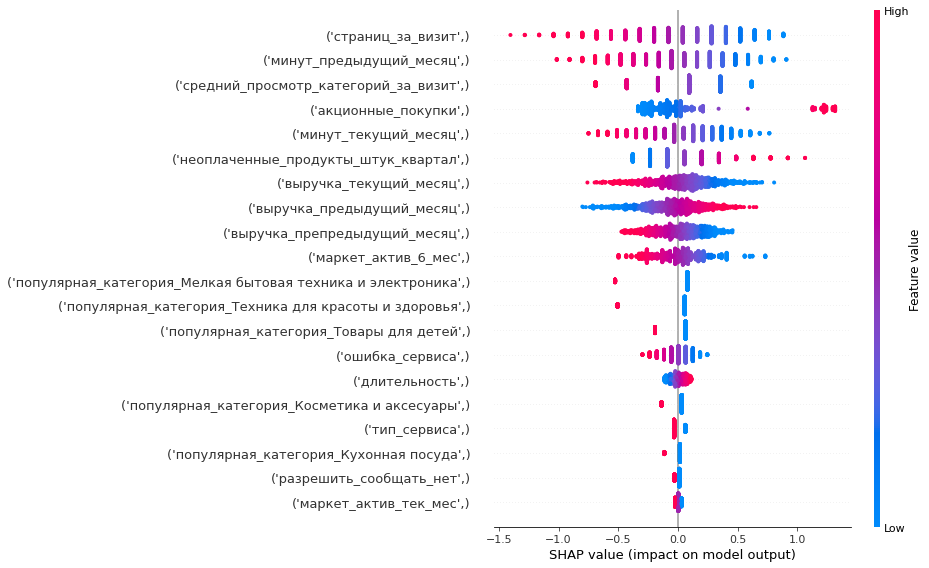

In [71]:

explainer = shap.LinearExplainer(pipe_best_model.named_steps['models'], X_train_get)
shap_values = explainer(X_train_get)

shap.plots.beeswarm(shap_values, max_display=25) 

1 - снизилась, 0 - прежний уровень  
Анализируя этот график можно сделать следующие выводы: Наибольшее влияние вносит фактор страниц_за визит. То есть чем меньше страниц посмотреть пользователь, тем меньше вероятность того, что активность останется на прежнем уровне.
  
   Также большое влияние вносит факторы, которые показывают сколько минут потратил человек, соответсвено чем меньше времени он потратил, тем больше вероятность того что активность снизится.
      
   Также интересно что ошибки сервиса немного влияют на активность покупателей, думаю что оптимизация - хорошее решение.
     
   Факторы [популярная_категория_Товары для детей, разрешить сообщать_нет, популярная_категория_Косметика и аксесуары, тип_сервиса, маркет_актив_тек_мес, популярная_категория_Кухонная посуда] практически не влияют на решение модели.

Здесь, в окружении Практикума стоит версия sklearn = 0.24.1, в этой версии достать названия фичей можно только так. Если обновить sklearn в начале тетрадки, то названия фичей можно достать так:
```python
feature_names = randomized_search.named_steps['preprocessor'].get_feature_names_out().tolist()    
```
Посмотреть версию библиотеки можно так:
```python
import sklearn
sklearn.__version__
```
Обновить до последней версии:
```
!pip install -Uq scikit-learn
```
Там могут быть ещё различия в названиях аргументов, нужно отследить возможные ошибки.</font>

## Сегментация

In [72]:
data_contact = X_test.merge(data_unity['прибыль'], on='id')
data_contact['вероятность_снижения'] = probabilities[:,1]

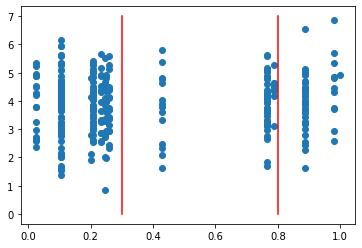

In [73]:
plt.scatter (probabilities[:,1], data_contact['прибыль'])
plt.plot([0.3, 0.3], [0, 7], 'k-', color = 'r')
plt.plot([0.8, 0.8], [0, 7], 'k-', color = 'r')
None

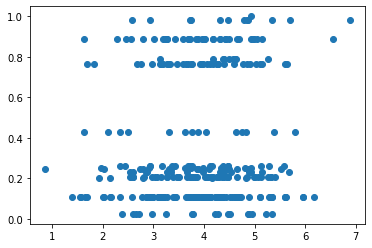

In [74]:
plt.scatter ( data_contact['прибыль'], probabilities[:,1])
None

Думаю что нас больше всего интересует тот сегмент, в котором высока вероятность того что активность снизится, и при этом прибыль высокая. Отделим этот сегмент границей 0.8 по вероятности и 4,5 по прибыли.

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='green'> 👍</font>

In [75]:
data_segm = data_contact.query('(прибыль > 4.5) and (вероятность_снижения > 0.8)')
data_segm.head()

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минут_предыдущий_месяц,минут_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,прибыль,вероятность_снижения
id,,,,,,,,,,,,,,,,,,
215737,стандарт,да,0.9,4,225,0.36,Косметика и аксесуары,2,4,2,3,9,10,5126.0,4679.0,5291.1,4.80,0.981132
215390,стандарт,да,3.1,4,152,0.33,Косметика и аксесуары,6,4,2,5,8,12,4254.0,4549.0,4612.8,5.70,0.981132
215604,стандарт,нет,3.1,5,458,0.99,Косметика и аксесуары,1,5,3,4,8,10,4449.0,4308.0,4459.4,4.86,0.981132
215600,стандарт,да,2.4,4,446,0.29,Кухонная посуда,1,6,3,4,13,14,6134.0,4646.0,5781.7,4.65,0.886179
215473,стандарт,нет,4.1,3,336,0.22,Домашний текстиль,2,7,2,3,8,13,4246.5,4224.0,3987.8,4.69,0.886179


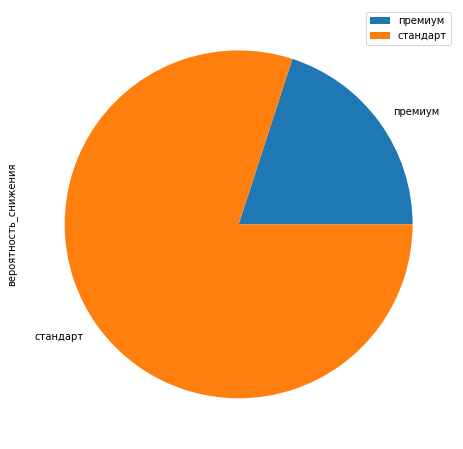

In [76]:
data_segm.pivot_table(index='тип_сервиса', values='вероятность_снижения', aggfunc='count').plot(kind='pie', subplots=True, figsize=(8,8))
None

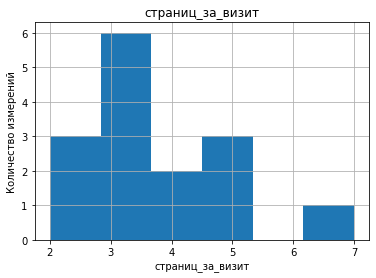

In [77]:
data_segm['страниц_за_визит'].hist(bins = 6)
plt.title("страниц_за_визит")
plt.ylabel("Количество измерений")
plt.xlabel("страниц_за_визит")
None

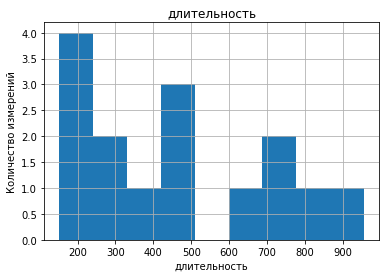

In [78]:
data_segm['длительность'].hist(bins = 9)
plt.title("длительность")
plt.ylabel("Количество измерений")
plt.xlabel("длительность")
None

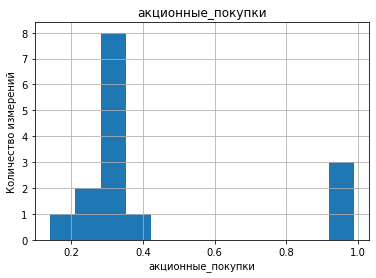

In [79]:

data_segm['акционные_покупки'].hist(bins = 12)
plt.title("акционные_покупки")
plt.ylabel("Количество измерений")
plt.xlabel("акционные_покупки")
None

Акционные покупки имеют большое влияние если верить shap. Вероятно если найти способ увеличить количество акционных покупок у данного сегмента, то это удержит их с большей вероятностью.

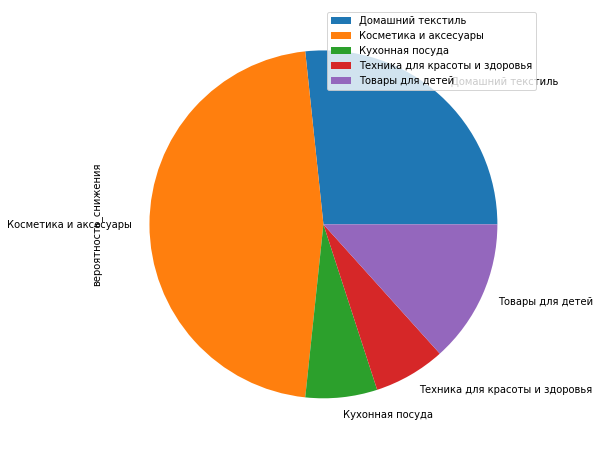

In [80]:

data_segm.pivot_table(index='популярная_категория', values='вероятность_снижения', aggfunc='count').plot(kind='pie', subplots=True, figsize=(8,8))
None

А вот тут что-то интересное. Среди тех кто приносит прибыль, но с большой вероятностью снизит активность популярна категория Кухонная посуда, хотя этот признак практически не имеет значения по shap. Думаю надо работать над разделом кухонная посуда и сделать его более привлекательным.

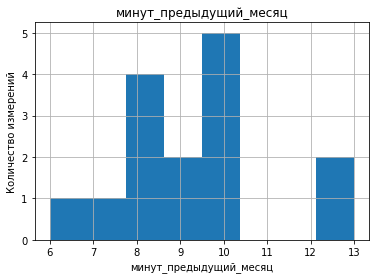

In [81]:

data_segm['минут_предыдущий_месяц'].hist(bins = 8)
plt.title("минут_предыдущий_месяц")
plt.ylabel("Количество измерений")
plt.xlabel("минут_предыдущий_месяц")
None

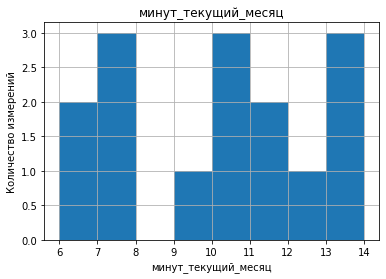

In [82]:
data_segm['минут_текущий_месяц'].hist(bins = 8)
plt.title("минут_текущий_месяц")
plt.ylabel("Количество измерений")
plt.xlabel("минут_текущий_месяц")
None

### Вывод

Из графиков выше видно, что если постараться сделать раздел Кухонной посуды более привлекательным, а также попробовать увеличить количество акционных покупок, то вероятность того, что клиенты которые приносят большую прибыль, однако вероятно снижят свою активность с большей вероятностью останется на прежнем уровне.

## Вывод

В ходе предобработки данных названия стоблцов были приведены к нижнему регистру и изменены для удобства дальнейшего исследования.
Были устранены аномалии, а также обработаны явные и неявные дубликаты. Исправлены некоторое ошибка в написаннии для удобства дальнейшего пользования.

В процессе ислледовательсткого анализа были построены графики всех параметров, а так же их ящики-с-усами. Были обработаны и изучены выбросы, были построены и изучены круговые диаграммы для бинарных столбцов.

Был проведен корреляционный анализ в ходе которого мы искали закономерности между данными, а также их изучали. Для установления закономерностей мы использовали метод Спирмана.

Был построен пайплайн внутри которого мы нормализировали и стандартизировали данные а также сравнивали модели в числе которых: DecisionTreeClassifier, KNeighborsClassifier, SVC, LogisticRegression. Среди них была найдена лучшая, которую мы применили в прогнозировании результата. Лучшей векторная SVC моедль.

Так же была проведена сегментация пользователей, и выдвинуты гипотезе по работе с пользователями, которые приносят прибыль но вероятно снизят свою активность в будущем.